In [1]:
import pandas as pd
from HSSL import *
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

In [ ]:
def find_cut(dendrogram):

    distances = [d[2] for d in dendrogram]
    distances.sort(reverse=True)
    
    max_jump = 0
    for i in range(len(distances) - 1):
        d = distances[i] - distances[i + 1]

        if d > max_jump:
            max_jump = d
            index = i
    
    return index + 1

In [3]:
def get_clustering_from_dendrogram(dendrogram, k, min_cluster_size=1):
    # roundup_fix_dendrogram(dendrogram)
    N = len(dendrogram) + 1
    clustering = -np.ones(N+len(dendrogram), dtype=int)
    merge_distance_order = np.argsort([v[2] for v in dendrogram], kind="stable")
    final_clusters = set([2*N-2])
    i = len(merge_distance_order)-1
    while len(final_clusters) < k:
        final_clusters.remove(N+i)
        l,r = dendrogram[merge_distance_order[i]][:2]
        l_size = 1 if l<N else dendrogram[l-N][3]
        r_size = 1 if r<N else dendrogram[r-N][3]
        if l_size >= min_cluster_size: final_clusters.add(l)
        if r_size >= min_cluster_size: final_clusters.add(r)
        i -= 1
    final_clusters = np.sort([*final_clusters])
    for i,c in enumerate(final_clusters): clustering[c] = i
    for merged_index_diff, (cluster_i, cluster_j, _, _) in enumerate(reversed(dendrogram)):
        merged_index = N + len(dendrogram) - merged_index_diff - 1
        if merged_index > final_clusters[-1]: continue
        clustering[[cluster_i, cluster_j]] = clustering[merged_index]
    return clustering[:N]
# clustering = get_clustering_from_dendrogram(dendrogram, 5, 5)
# print(np.unique(clustering, return_counts=True))
# clustering

In [4]:
def ARI_score(path1, path2):
        with h5py.File(path1, "r") as f:
                dendro1 = f['dendrogram_data'][:]
        dendro1 = [[int(l), int(r), float(d), int(s)] for l, r, d, s in dendro1]

        dendro1 = elki_sort_dendrogram(dendro1)
        k = find_cut(dendro1)
        print(k)
        C1 = get_clustering_from_dendrogram(dendro1, k)

        with h5py.File(path2, "r") as f:
                dendro2 = f['dendrogram_data'][:]
        dendro2 = [[int(l), int(r), float(d), int(s)] for l, r, d, s in dendro2]

        dendro2 = elki_sort_dendrogram(dendro2)
        C2 = get_clustering_from_dendrogram(dendro2, k)

        # len([v for v in C if v == 3])

        return adjusted_rand_score(C1, C2)

In [5]:
p1 = 'results/blobs_n=8000_centers=5/HNSW_HSSL/dendro.hdf5'
p2 = 'results/blobs_n=8000_centers=5/HSSL_Turbo/dendro.hdf5'

ARI_score(p1, p2)

5


0.782488191995628

In [6]:
import traceback
import os
from typing import Any, Optional, Set, Tuple, Iterator

def build_result_filepath(dataset_name: Optional[str] = None, 
                          eps: Optional[float] = None,
                          minPts: Optional[int] = None,
                          algorithm: Optional[any] = None,
                          arguments: Optional[Any] = None) -> str:
    d = ["results"]
    if dataset_name:
        d.append(dataset_name)
    if eps:
        d.append(str(eps))
    if minPts:
        d.append(str(minPts))
    if algorithm:
        d.append(algorithm)
        #data = definition.arguments + query_arguments
        #d.append(re.sub(r"\W+", "_", json.dumps(data, sort_keys=True)).strip("_") + ".hdf5")
        if arguments:
            d.append(arguments+".hdf5")
        else:
            d.append("run.hdf5")
    return os.path.join(*d)

def load_all_results(dataset: Optional[str] = None, prefix: str = ".") -> Iterator[Tuple[h5py.File]]:
    for root, _, files in os.walk(os.path.join(prefix, build_result_filepath(dataset))):
        for filename in files:
            if os.path.splitext(filename)[-1] != ".hdf5":
                continue
            try:
                with h5py.File(os.path.join(root, filename), "r+") as f:
                    yield f
            except Exception:
                print(f"Was unable to read {filename}")
                traceback.print_exc()

In [7]:
datasets = ['blobs_n=2000_centers=5',
            'blobs_n=4000_centers=5',
            'blobs_n=8000_centers=5',
            'blobs_n=16000_centers=5',
            'blobs_n=32000_centers=5',
            'blobs_n=64000_centers=5',
            'blobs_n=128000_centers=5',
            # 'cancer', 
            # 'iris', 
            # 'wine',
            # 'mnist'
            ]

data = []

# load all the results that are available for the dataset
for S in datasets:
    for f in load_all_results(S, ""):
        data.append({
            "algo": f['algo'][0].decode(), 
            "time": f['time'][0], 
            "n": f['n'][0]
            })

df = pd.DataFrame(data=data)
df

,algo,time,n
0,HNSW_HSSL,12.242057,2000
1,HSSL_Turbo,12.186026,2000
2,HNSW_HSSL,24.735461,4000
3,HSSL_Turbo,43.004570,4000
4,HNSW_HSSL,65.565953,8000
5,HSSL_Turbo,166.924440,8000
6,HNSW_HSSL,167.496854,16000
7,HSSL_Turbo,751.138710,16000
8,HNSW_HSSL,465.742020,32000
9,HSSL_Turbo,3802.269429,32000


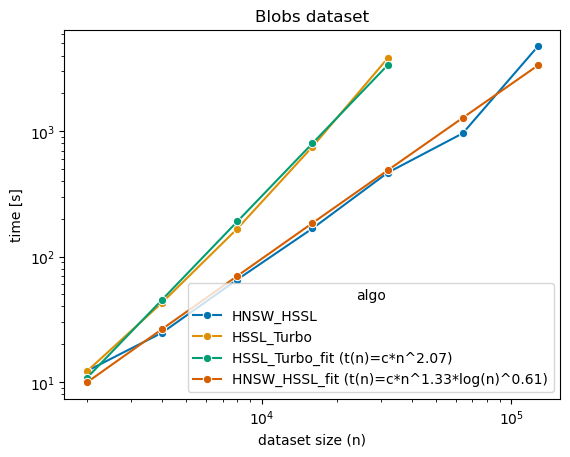

In [8]:
import seaborn as sns
from scipy.stats import linregress
from scipy.optimize import minimize

plot_df = df.copy()
fit_xs = df[df["algo"]=="HSSL_Turbo"]["n"].to_numpy()
fit_ys = df[df["algo"]=="HSSL_Turbo"]["time"].to_numpy()
sel = np.argsort(fit_xs)[:]
fit_model = linregress(np.log(fit_xs[sel]),np.log(fit_ys[sel]))
plot_df = pd.concat([plot_df, pd.DataFrame([
    [f"HSSL_Turbo_fit (t(n)=c*n^{fit_model.slope:.2f})", x**fit_model.slope * np.exp(fit_model.intercept), x]
    for x in fit_xs
], columns=plot_df.columns)], axis=0)

def poly_log_fit(x, params):
    a,b,c = params
    return a*x**b*np.log(x)**c
def poly_log_fit_opt(x,y):
    def target(params):
        return np.sum(np.square(np.log(poly_log_fit(x,params))-np.log(y)))
    result = minimize(target, np.array([y[0]/x[0],1,0]), bounds=[
        (1e-20, 1e2*y[0]/x[0]),
        (1, 3),
        (0, 4)
    ])
    return result.x, result.fun
fit_xs = df[df["algo"]=="HNSW_HSSL"]["n"].to_numpy()
fit_ys = df[df["algo"]=="HNSW_HSSL"]["time"].to_numpy()
sel = np.argsort(fit_xs)[:]
model_params, score = poly_log_fit_opt(fit_xs[sel],fit_ys[sel])
# print(model_params, score)
plot_df = pd.concat([plot_df, pd.DataFrame([
    [f"HNSW_HSSL_fit (t(n)=c*n^{model_params[1]:.2f}*log(n)^{model_params[2]:.2f})", poly_log_fit(x,model_params), x]
    for x in fit_xs
], columns=plot_df.columns)], axis=0)


ax = sns.lineplot(data=plot_df, x='n', y='time', hue="algo", marker='o', palette="colorblind")
ax.set_title('Blobs dataset')
ax.set_xlabel('dataset size (n)')
ax.set_ylabel('time [s]')
ax.set_xscale("log")
ax.set_yscale("log")

# Set gridlines and ticks
# x_log_min = np.log10(min(times['eps']))
# x_log_max = np.log10(max(times['eps']))
# xticks = np.logspace(x_log_min, x_log_max, num = 7)
# xticks = [round(x, 1) for x in xticks]
# y_log_min = np.log10(min(times['time']))
# y_log_max = np.log10(max(times['time']))
# yticks = np.logspace(y_log_min, y_log_max, num = 5)
# yticks = [int(x) for x in yticks]
# ax.set_xticks(xticks)
# ax.set_xticklabels(xticks)
# ax.set_yticks(yticks)
# ax.set_yticklabels(yticks)

In [9]:
dataset = ['wine', 'iris']

# load all the results that are available for the dataset
for S in dataset:
    for f in load_all_results(S, ""):
        print(f.keys())

<KeysViewHDF5 ['algo', 'dendrogram_data', 'n', 'time']>
<KeysViewHDF5 ['algo', 'dendrogram_data', 'n', 'time']>
<KeysViewHDF5 ['algo', 'dendrogram_data', 'n', 'time']>
<KeysViewHDF5 ['algo', 'dendrogram_data', 'n', 'time']>


In [ ]:
path = 'results/blobs_n=2000_centers=5/HSSL_Turbo/dendro.hdf5'
# path = 'results/iris/HSSL_Turbo/dendro.hdf5'

with h5py.File(path, 'r') as f:
    print(list(f.keys()))
    print(len(f['dendrogram_data']), f['n'][0] - 1)

['algo', 'dendrogram_data', 'n', 'time']
7999 7999


In [11]:
path = 'datasets/blobs_n=2000_centers=5.hdf5'

with h5py.File(path, 'r') as f:
    print(list(f.keys()))
    print(len(f['data'][:]))

['data']
2000
